<a href="https://colab.research.google.com/github/brijeshbv/combinatorial-optimisation/blob/main/regression_neural_network_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import jax

print("JAX Version : {}".format(jax.__version__))

from jax import numpy as jnp
from jax import grad, value_and_grad
from jax.example_libraries import optimizers
from jax import random, jit
from functools import partial
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

!pip install scprep
import scprep

input_features = 3
centre_of_sphere = np.array([0,0,0])

JAX Version : 0.3.14
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


A Relu function to generate the Activation

In [ ]:
def Relu(x):
    return jnp.maximum(x, jnp.zeros_like(x)) # max(0,x)

In [ ]:
def NoOp(x):
  return x

A function to generate both normally distributed input data and corresponding mapped output data for a spherical surface

In [ ]:
def GenerateDistAndSphere(batchno, batchsize, seed):
  seed, key = random.split(seed)
  x = random.normal(key, [batchno, batchsize, 3])
  radius = jnp.sqrt(jnp.sum(jnp.square(x-centre_of_sphere), axis=-1, keepdims=True))
  print("radius",np.shape(radius))
  target = x / radius
  return x, target, seed

In [ ]:
def InitializeWeights(layer_sizes, seed):
    w = []
    b = []
    for i in range(1,layer_sizes.shape[0]):
      seed, key = random.split(seed)
      w0 = random.normal(key, (layer_sizes[i], layer_sizes[i-1]))
      w0 = w0 * jnp.sqrt(2 / (layer_sizes[i]+layer_sizes[i-1]))
      w.append(w0)
      b.append(jnp.zeros((layer_sizes[i],1)))
    return [w,b] , seed

In [ ]:
@jit
def Predict(input_data, weights):
  w, b = weights
  no_of_layers = len(w)
  print("no of layers:", no_of_layers)
  h = input_data
  for layer in range(no_of_layers-1):
    h = LinearLayer(weights,h, layer, Relu)
  h = LinearLayer(weights,h, no_of_layers-1, NoOp)
  return h

In [ ]:
def LinearLayer(weights, input_data,layer, activation=lambda x: x):
  w, b = weights
  out = jnp.matmul(input_data,w[layer].T) + b[layer].T
  return activation(out)

In [ ]:
@partial(jit, static_argnums=(1,))
def MeanSquaredErrorLoss(phi, nn, input, target):
  output = nn(input, phi)
  theloss = jnp.mean(jnp.square(target-output))
  aux = theloss
  return theloss, aux

def TrainModel(x, target, weights, nn, epochno):
  no_of_batches, batchsize, _ = x.shape
  step_size = 5e-3
  opt = optimizers.adam(step_size)
  opt_init, opt_update, opt_get_params = opt
  opt_state = opt_init(weights)

  lossline = jnp.array([0])
  for epochs in range(epochno):
    for batchno in range(no_of_batches):
      x_i = x[batchno,:,:]
      target_i = target[batchno,:,:]
      grads, aux = grad(MeanSquaredErrorLoss, argnums=0, has_aux=True)(weights,nn, x_i, target_i)
      opt_state = opt_update(batchno, grads, opt_state)
      weights = opt_get_params(opt_state)
      loss_now = aux
      lossline = jnp.append(lossline, loss_now)
      if batchno % 50 == 0:
        print('\rbatch no', batchno, end='')

  print('\n')
  return weights, lossline[1:]


Input Diagnostics

In [ ]:
def VisualizeAndCompare(phi, nn, target, lossline, rng, batch_size, no_of_batches, epochno):

  x_t, target_t, rng = GenerateDistAndSphere(1, 1000, rng)
  x_t = jnp.squeeze(x_t)
  target_t = jnp.squeeze(target_t)

  testloss, _ = MeanSquaredErrorLoss(phi, nn, x_t, target_t)
  y_t = nn(x_t, phi)
  print('train loss is', lossline[-1], 'test loss is', testloss)

  fig = plt.figure(figsize=(12,12))
  fig.suptitle('Linear regression results with \n epochno: ' + str(epochno) + ' '+ 'no_of_batches: '+ str(no_of_batches) + ' '+ 'batch_size: ' + str(batch_size) + ' ', fontsize=16)
  ta = jnp.vstack(target)
  ax = fig.add_subplot(2,2,1, projection='3d')
  ax.scatter3D(ta[:,0], ta[:,1], ta[:,2], c=ta[:,0], marker='.')
  plt.title('target data used in training')
  ax.set_xticks([-1, 0, 1])
  ax.set_yticks([-1, 0, 1])
  ax.set_zticks([-1, 0, 1])
  ax = fig.add_subplot(2,2,2, projection='3d')
  ax.scatter3D(y_t[:,0], y_t[:,1], y_t[:,2], c=y_t[:,0], marker='.')
  plt.title('test output data')
  ax.set_xticks([-1, 0, 1])
  ax.set_yticks([-1, 0, 1])
  ax.set_zticks([-1, 0, 1])
  ax = fig.add_subplot(2,2,3)
  losslineTitle = "L2 loss"
  ax.plot(lossline)
  ax.set_xlabel('batch')
  ax.set_xlabel('loss')

  return y_t
  


In [ ]:
def TestNeuralNetwork():
  rng = random.PRNGKey(0)
  layerDims = jnp.array((1,4,3,1))
  phi, rng = InitializeWeights(layerDims, rng)
  rng, key = random.split(rng)
  input = random.normal(key, [3, layerDims[0]])
  output = Predict( input, phi)

TestNeuralNetwork()

no of layers: 3


Linear regression results with 
 epochno: 1 no_of_batches: 300 batch_size: 50 
radius (300, 50, 1)
(300, 50, 3) (300, 50, 3)
no of layers: 3
batch no 200

radius (1, 1000, 1)
no of layers: 3
no of layers: 3
train loss is 0.016092569 test loss is 0.010084253
Linear regression results with 
 epochno: 3 no_of_batches: 300 batch_size: 50 
radius (300, 50, 1)
(300, 50, 3) (300, 50, 3)
batch no 200

radius (1, 1000, 1)
train loss is 0.008197469 test loss is 0.0042223674
Linear regression results with 
 epochno: 5 no_of_batches: 300 batch_size: 50 
radius (300, 50, 1)
(300, 50, 3) (300, 50, 3)
batch no 200

radius (1, 1000, 1)
train loss is 0.0064045126 test loss is 0.0034788393
Linear regression results with 
 epochno: 1 no_of_batches: 500 batch_size: 50 
radius (500, 50, 1)
(500, 50, 3) (500, 50, 3)
batch no 350

radius (1, 1000, 1)
train loss is 0.003919311 test loss is 0.0054536196
Linear regression results with 
 epochno: 3 no_of_batches: 500 batch_size: 50 
radius (500, 50, 1)
(500, 50,

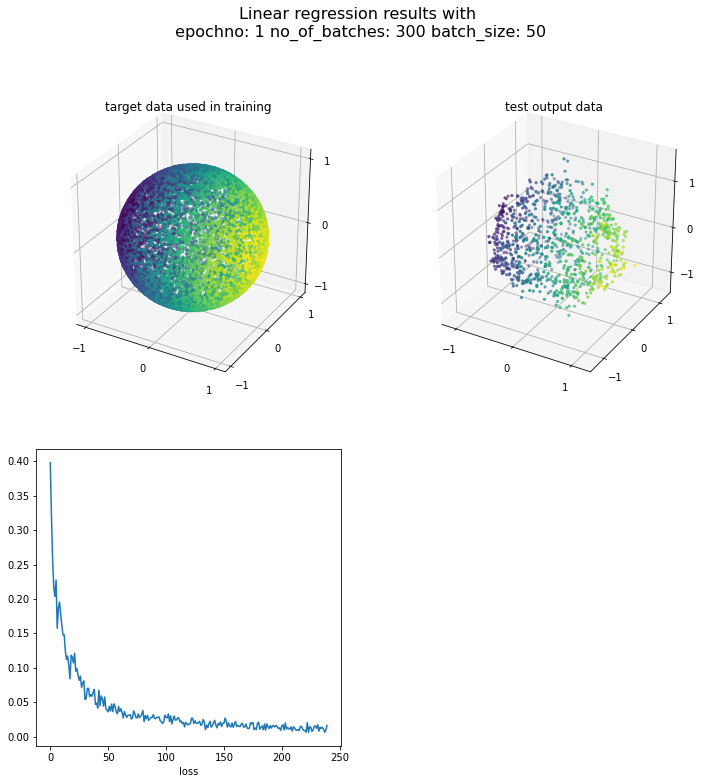

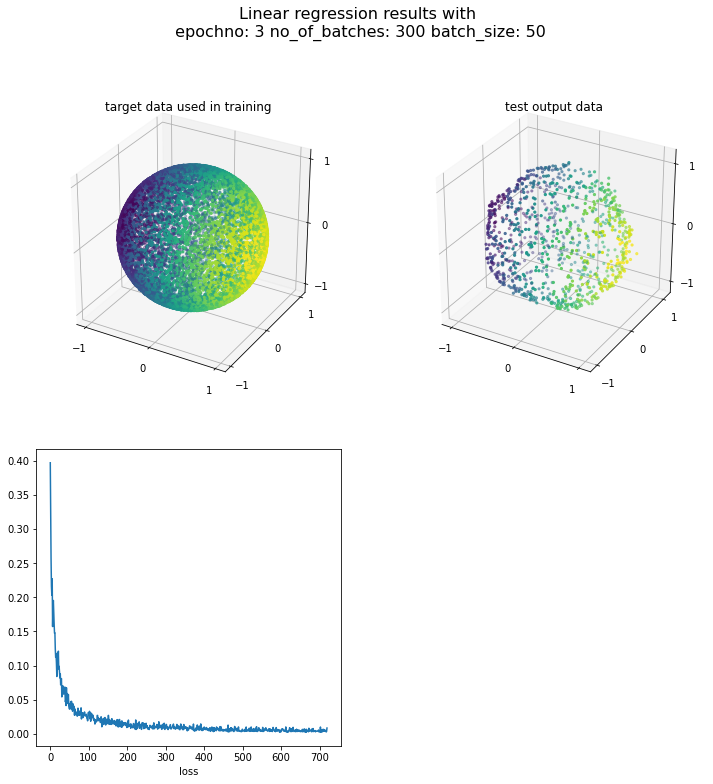

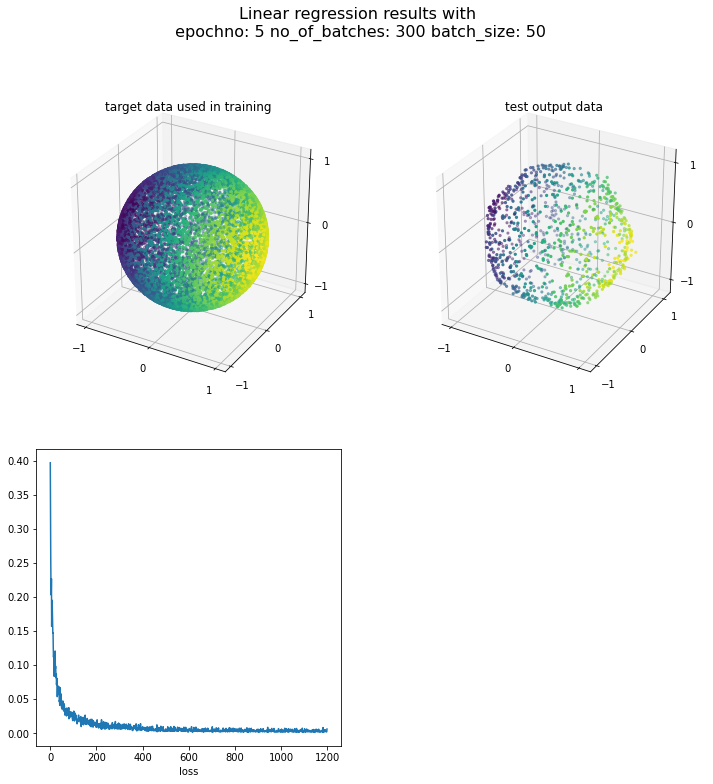

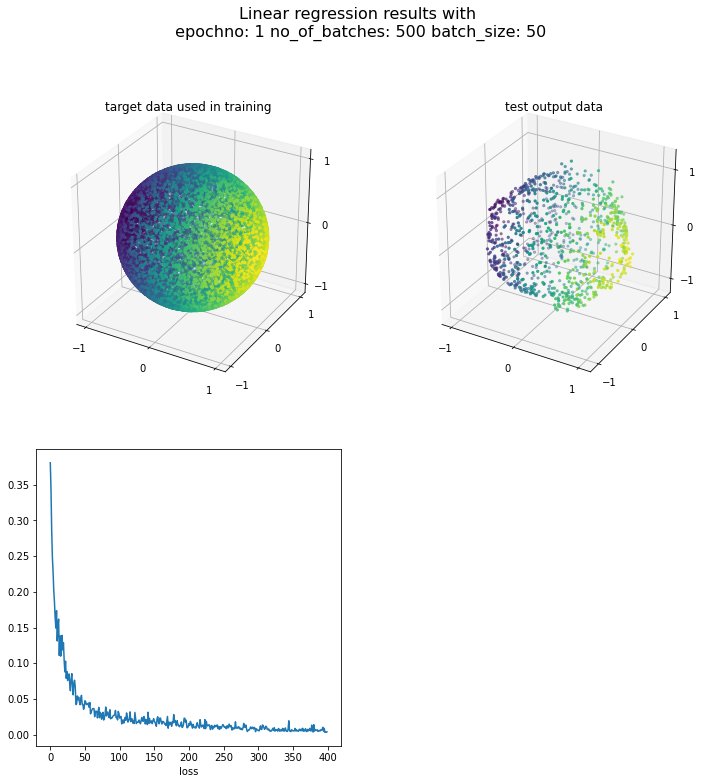

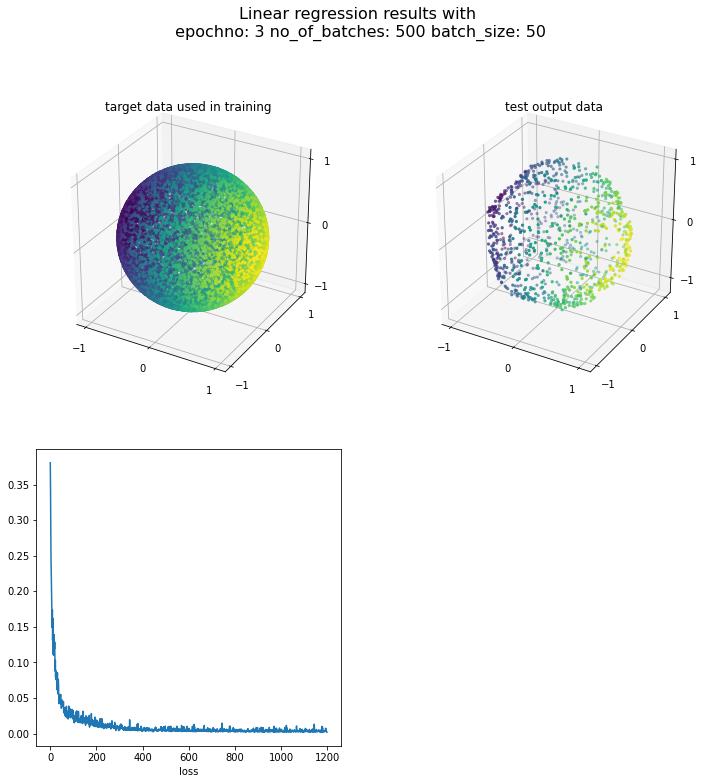

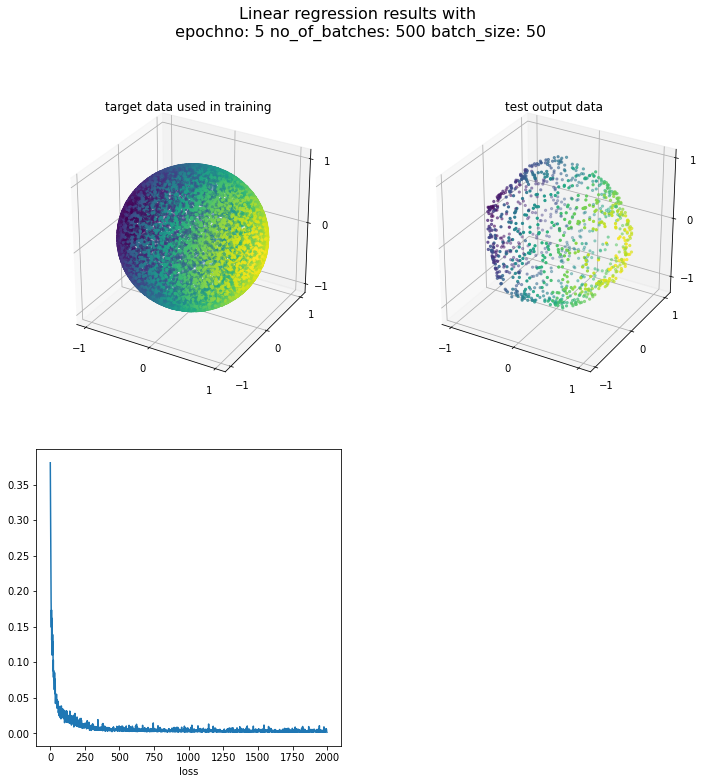

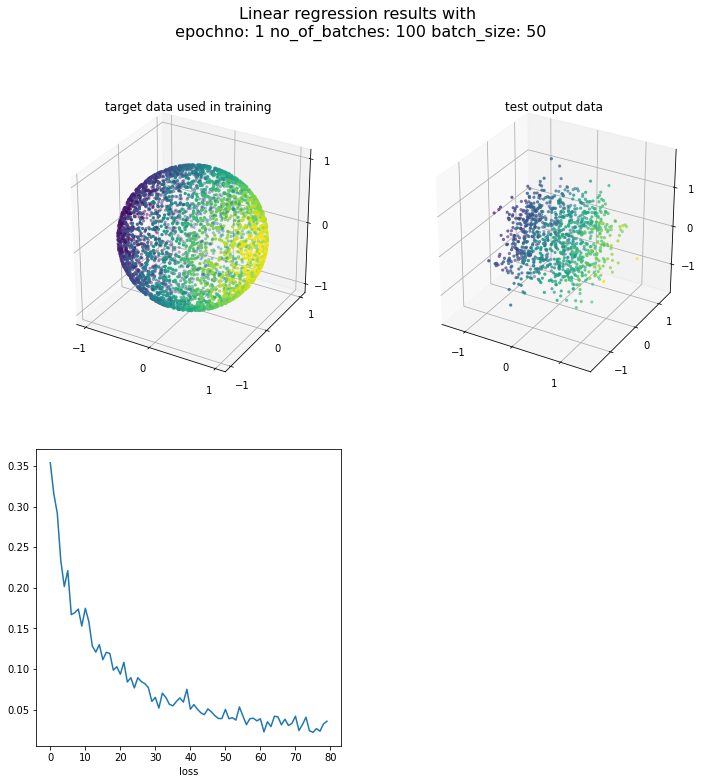

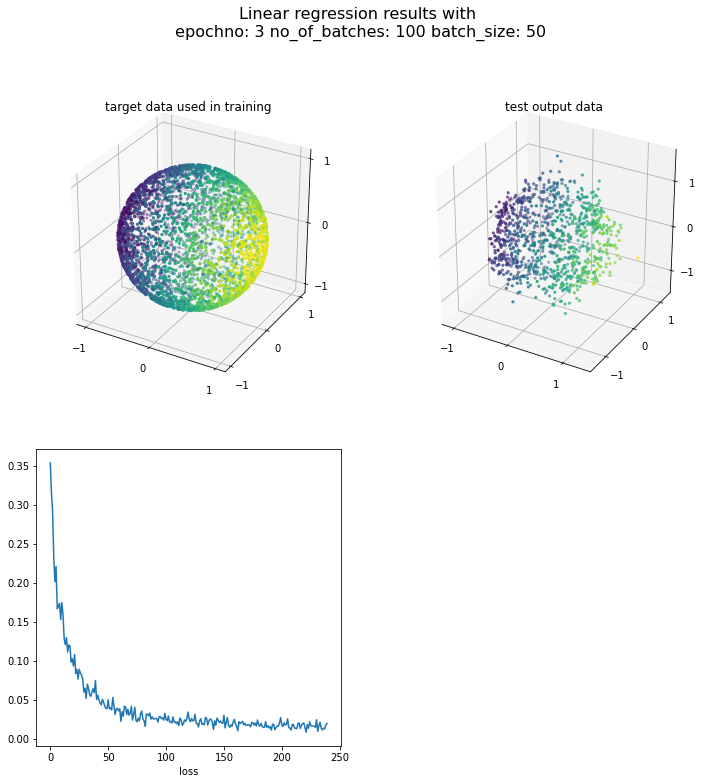

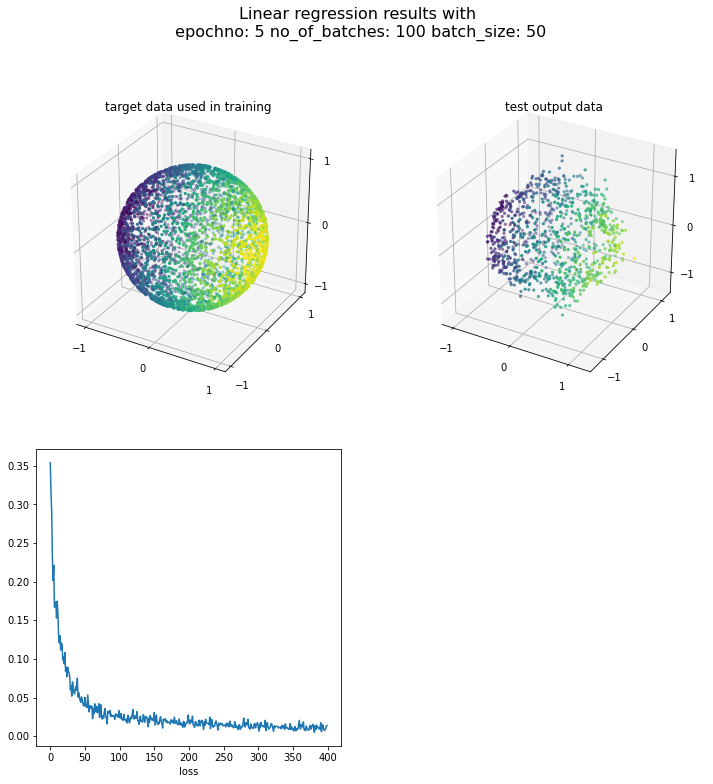

In [ ]:
layers = np.array([3,16,16,3])
no_of_epochs_array = [1, 3, 5]
no_of_batches_array = [300, 500, 100]
batch_size = 50

def main(batch_size, no_of_batches, epochno, layerDims):
  seed = random.PRNGKey(2)
  init_nn = InitializeWeights
  nn = TrainModel
  x, y, seed = GenerateDistAndSphere(no_of_batches, batch_size, seed)
  X_train, X_val, Y_train, Y_val = train_test_split(x, y, train_size=0.8, random_state=123)
  weights, seed = init_nn(layerDims,seed)
  print(x.shape, y.shape)
  weights , lossline = nn(X_train, Y_train, weights, Predict,epochno)
  _ , validationLossLine = nn(X_val, Y_val, weights, Predict,epochno)
  VisualizeAndCompare(weights, Predict, Y_train, lossline, seed,batch_size, no_of_batches, epochno)
  return 

for no_of_batches in no_of_batches_array:
  for no_of_epochs in no_of_epochs_array:
    print('Linear regression results with \n epochno: ' + str(no_of_epochs) + ' '+ 'no_of_batches: '+ str(no_of_batches) + ' '+ 'batch_size: ' + str(batch_size) + ' ')
    main(batch_size=batch_size,no_of_batches=no_of_batches,epochno=no_of_epochs, layerDims= np.array([3,16,16,3]))
